# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model

from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

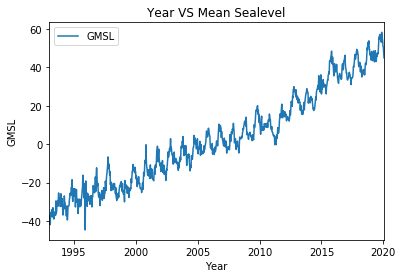

In [2]:
#loading the data 
sea_data = pandas.read_csv("sealevel.csv")

# Total number of observations in the data
sea_data.shape

#plotting the time series
sea_data.plot(x='Year',y='GMSL')
plt.ylabel('GMSL')
plt.xlabel('Year')
plt.title('Year VS Mean Sealevel')
plt.legend()
plt.show()

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:** It is necessary to fit a stationary AR model(with constant mean and constant variance) in order to make further calculations accurately since if the process is not stationary, the variance increases as a function of time tag making the prediction vary with a greater magnitude. As seen from the graph  for the mean of the observed data is not constatnt and we observe an upward trend, but the variance of the data is constant. Hence we remove this trend to transform the available data into data having a constant mean.

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

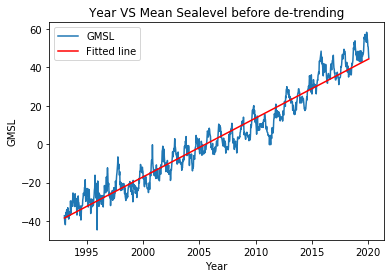

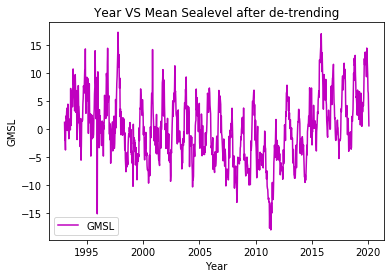

In [11]:
# Splitting into X and Y
n = sea_data.shape[0]
X = sea_data[['Year']].values.reshape(n,1)
Y = sea_data['GMSL'].values

#Performing Linear regression
regressor=lm.LinearRegression()
model=regressor.fit(X, Y)

#Predicting the with linear regression
Y_hat=regressor.predict(X)

# Subtracting the predicted value from original values 
Y_new=Y-Y_hat

#Cheking if the mean value is close to 0
np.mean(Y_new)

#Plotting the data with the trend

plt.plot(X,Y,label='GMSL')
plt.plot(X,Y_hat,label="Fitted line",c='r')
plt.ylabel('GMSL')
plt.xlabel('Year')
plt.title('Year VS Mean Sealevel before de-trending')
plt.legend()
plt.show()

# Plotting the new data
plt.plot(X,Y_new,label='GMSL',c='m')
plt.ylabel('GMSL')
plt.xlabel('Year')
plt.title('Year VS Mean Sealevel after de-trending')
plt.legend()
plt.show()

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

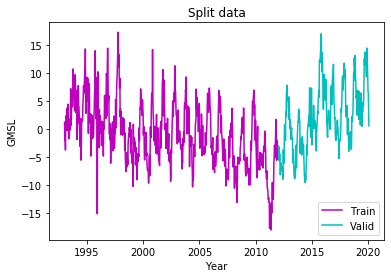

In [12]:
X_train = X[0:700].flatten()
X_valid = X[700:].faltten()
Y_train = Y_new[0:700].flatten()
Y_valid = Y_new[700:].flatten()

plt.plot(X_train,Y_train,label="Train",color='m')
plt.plot(X_valid,Y_valid,label="Valid",color='c')
plt.ylabel('GMSL')
plt.xlabel('Year')
plt.title('Split data')
plt.legend()
plt.show()

In [13]:
print("Train shape",X_train.shape)
print("Validation shape",X_valid.shape)

Train shape (700, 1)
Validation shape (297, 1)


## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [14]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """
    # Number of training data points
    n = len(y)
    
    # Construct the regression matrix
    Phi = np.zeros(shape=(n-p, p))
    for j in range(p):
        Phi[:,j] = y[j:n-p+j]
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

 
    return regr.coef_

In [15]:
theta_hat = fit_ar(Y_train,10)
print("Theta hat",theta_hat)

Theta hat [ 0.02305208 -0.11175939  0.07585221 -0.09578106 -0.05955406 -0.02184709
  0.1745703   0.15104657  0.10763277  0.62156052]


**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [16]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = len(theta)
    
    # Number of one-step predictions for Y_target
    m = n-p
    y_pred = np.zeros(m)
    
    for i in range(m):
        y_pred[i] = np.dot(y_target[i:p+i],theta)
        
    return y_pred

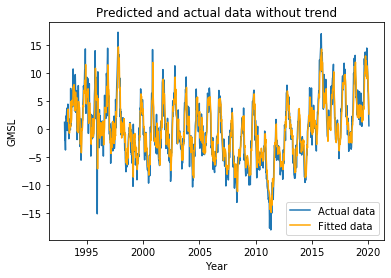

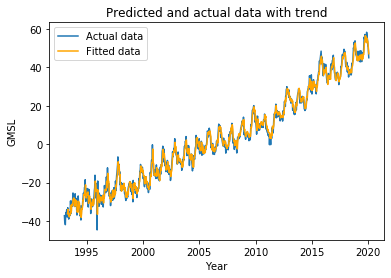

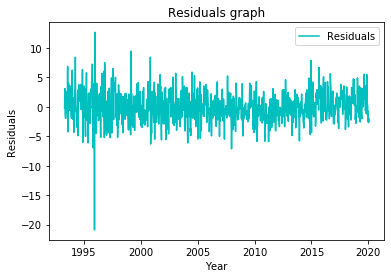

In [17]:
Y_hat = predict_ar_1step(theta_hat,Y_new)

residuals = (Y_new[10:]-Y_hat)

plt.plot(X,Y_new,label='Actual data')
plt.plot(X[10:],Y_hat,color='orange',label='Fitted data')
plt.ylabel('GMSL')
plt.xlabel('Year')
plt.title('Predicted and actual data without trend')
plt.legend()
plt.show()

trend = regressor.predict(X[10:])

Y_hat_trend = Y_hat+trend

plt.plot(X,Y,label='Actual data')
plt.plot(X[10:],Y_hat_trend,color='orange',label='Fitted data')
plt.ylabel('GMSL')
plt.xlabel('Year')
plt.title('Predicted and actual data with trend')
plt.legend()
plt.show()

plt.plot(X[10:],residuals,color='c',label='Residuals')
plt.ylabel('Residuals')
plt.xlabel('Year')
plt.title('Residuals graph')
plt.legend()
plt.show()

In [18]:
valid_residuals = residuals[-297:]

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

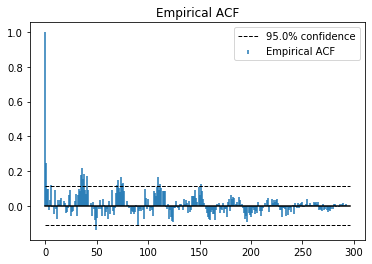

In [19]:
acfplot(valid_residuals)

From the ACF plot, it can be observed that the correlation was high,varying a lot initially but with time it reduces to a constant value of zero. This implies the process was initially unstationary (as the variance was not constant) but with time it becomes stationary(since variance reaches a constant value 0), making it a stable process after 300 points i.e approximately 10 months at a confidence interval of 95%.

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

In [20]:
MSE_train = np.zeros(149)
MSE_valid = np.zeros(149)

ps = np.array(range(2,151))
i = 0
for p in ps:
    theta_hat = fit_ar(Y_train,p)
    Y_hat = predict_ar_1step(theta_hat,Y_new)
    MSE_train[i] = np.mean((Y_train[p:]-Y_hat[0:700-p])**2) 
    MSE_valid[i] = np.mean((Y_valid-Y_hat[700-p:])**2)
    i = i+1
#print(mino)
#print(min_mse)

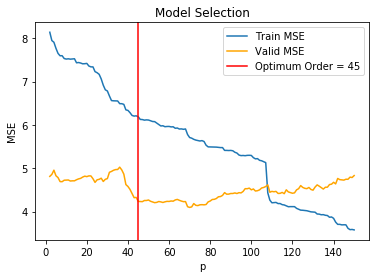

In [21]:
plt.plot(ps,MSE_train,label='Train MSE')
plt.plot(ps,MSE_valid,color='orange',label='Valid MSE')
plt.axvline(x = 45,c = 'red', label = "Optimum Order = 45")
plt.ylabel('MSE')
plt.xlabel('p')
plt.title('Model Selection')
plt.legend()
plt.show()

From the graph it can be seen that theere is a steep decrease in the validation MSE at p = 45 after that there is no much decrese in the MSE. Hence we choose the order 45 as the optial modal for the other calculations.

**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

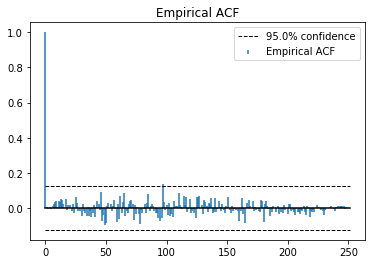

In [22]:
p=45

theta_hat=fit_ar(Y_valid,p)

Y_valid_hat = predict_ar_1step(theta_hat,Y_valid)

valid_residuals = Y_valid[p:]-Y_valid_hat

acfplot(valid_residuals)



The ACF function of the residuals when p=68 reaches a constant value of 0 around 250 points and becomes a stable process, 50 points before when p=10 becomes stable. Since it is reaching the desired state much earliter, p = 45 model will make better predictions before p = 10 model does.

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [ ]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """
    p = len(theta)    
    y_sim = np.zeros(m)
    n = len(y)
    
    phi = y[-p:] # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point
    
    y = y.flatten()
    
    for i in range(m):
        #Predicting one step
        y_sim[i] = np.dot(phi,theta)
        #Appending the prediction with y so that we can use it in the next prediction.
        y = np.append(y,y_sim[i])
        #Calculating the new phi with the appended data
        phi = y[-p:]
        
    return y_sim

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:**

In [62]:
theta_hat = fit_ar(Y_train,45)
Y_sim = simulate_ar(Y_valid,theta_hat,2000)
X_sim = np.zeros(2000)
h = X[2]-X[1]
for i in range(2000):
    X_sim[i] = X[996]+(h*i)

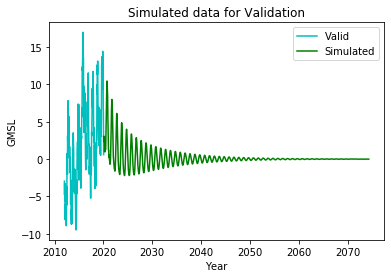

In [67]:
#plt.plot(X_train,Y_train,label="Train",color='m')
plt.plot(X_valid,Y_valid,label="Valid",color='c')
plt.plot(X_sim,Y_sim,label="Simulated",c='g')
plt.ylabel('GMSL')
plt.xlabel('Year')
plt.title('Simulated data for Validation')
plt.legend()
plt.show()

In [64]:
print("The a_j values for p = 45 {}".format(theta_hat))

The a_j values for p = 45 [-0.06361375  0.03742584 -0.05870399 -0.04744224 -0.00222717 -0.00622451
 -0.09866938  0.0326707   0.0219799   0.09494599  0.03895167  0.02693553
  0.03287225  0.08974676  0.04064638 -0.03714722  0.04347647  0.00417608
 -0.00993608 -0.03270368 -0.01890969  0.03855364 -0.06741151 -0.01978242
 -0.00814104  0.0424746  -0.02590256 -0.0171752   0.0973961  -0.02405147
  0.07995441 -0.07964321  0.01401588 -0.04227415 -0.05839977  0.06477459
 -0.08228283  0.11096105 -0.06673185  0.02702734  0.03374031  0.16129034
  0.12339498  0.07648872  0.48265474]


An AR process with mean 0 and a constant variance is choosen to model the GMSL data. Though the varaince is not constant in the begining, as the process becomes stable, the variance reaches a constant value of 0 as a_j<0. In addition to this, the AR process has a 0 mean, all the values tend to 0 as the process becomes stable.

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

In [136]:
def NAR_model(layer_sizes,solver,act_fun,max_iter = 200):
    p = 45
    n = Y_train.shape[0]

    # Construct a regression matrix
    Phi = np.zeros(shape=(n-p, p))
    for j in range(p):
        Phi[:,j] = Y_train[j : n-p+j]   

    # Drop the first p values from the target vector y
    yy = Y_train[p:,]

    p = 45
    n = Y_train.shape[0]

    # Construct a regression matrix
    Phi = np.zeros(shape=(n-p, p))
    for j in range(p):
        Phi[:,j] = Y_train[j : n-p+j]   

    # Drop the first p values from the target vector y
    yy = Y_train[p:,]

    # Fitting the model for traning data.
    NAR_model = MLPRegressor(hidden_layer_sizes = layer_sizes,
                             solver = solver,
                            activation = act_fun,
                            max_iter = max_iter).fit(Phi,yy)

    # Construct a regression matrix
    n = Y_new.shape[0]

    Phi = np.zeros(shape=(n-p, p))
    for j in range(p):
        Phi[:,j] = Y_new[j : n-p+j] 

    Y_hat_NAR = NAR_model.predict(Phi)
    Ytr_hat_NAR = Y_hat_NAR[0:700-p]
    Yva_hat_NAR = Y_hat_NAR[700-p:]

    residuals_NAR = Y_new[p:]-Y_hat_NAR
    res_train = residuals_NAR[0:700-p]
    res_valid = residuals_NAR[700-p:]
    
    # Plotting for Train data
    plt.plot(X_train,Y_train,label="Train",color='m')
    plt.plot(X_train[p:],Ytr_hat_NAR,label="Predicted",c='y')
    plt.plot(X_train[p:],res_train,label="Residuals",c='r')
    plt.ylabel('GMSL')
    plt.xlabel('Year')
    plt.title('One-Step Prediction for Training data')
    plt.legend()
    plt.show()

    # Plotting for Validation data
    plt.plot(X_valid,Y_valid,label="Valid",color='c')
    plt.plot(X_valid,Yva_hat_NAR,label="Predicted",c='y')
    plt.plot(X_valid,res_valid,label="Residuals",c='r')
    plt.ylabel('GMSL')
    plt.xlabel('Year')
    plt.title('One-Step Prediction for Validation data')
    plt.legend()
    plt.show()
    
    return([Ytr_hat_NAR,Yva_hat_NAR,res_train,res_valid])

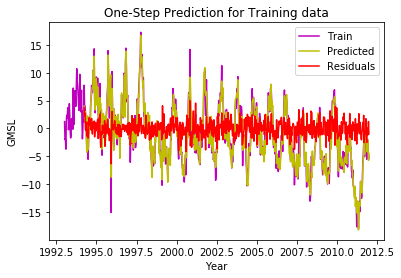

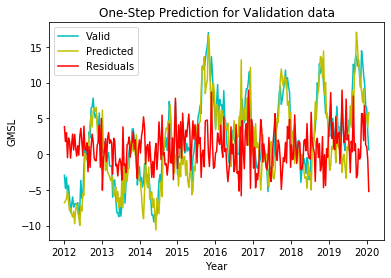

In [138]:
nar_res1 = NAR_model(layer_sizes = (10,),
                   solver = 'lbfgs',
                   act_fun = 'relu')

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:**

Tried 10 different combinations of the hyperparameters.

From the results below we can see that, the function does not converge for 'sgd' or 'adam' optimizers/solvers, hence 'lbfgs' is the best method. We need to find the other hyperparameters.The number of hidden layers, units per layer and maximum iterations can take any value ,activation function has 4 choices (‘identity’, ‘logistic’, ‘tanh’, ‘relu’) and the optimizer has 3 choices (lbfgs’, ‘sgd’, ‘adam’).Say for optimization purpose, we choose 5 values each for hidden layers, units per layer and maximum iterations, then we need to test 1500 combinations and select the modal which is impossible. Hence we can use a grid search method to find the optimum hyperparameters but is computationally taxing. Among the above compared methods, the modal with 'lbfgs' optimizer 10 perceptrons with a single layer performs the best. Even there for the validation data that the residuals increase with increase in time and bacome almost comparable to the predictions. The AR modal is the best as it is not computationally taxing also the variation in magnitude of the residuals decreases with time.

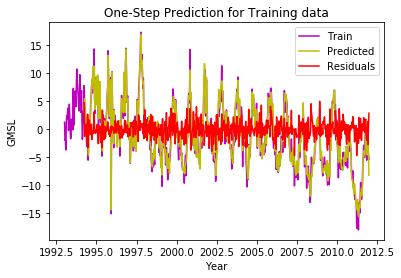

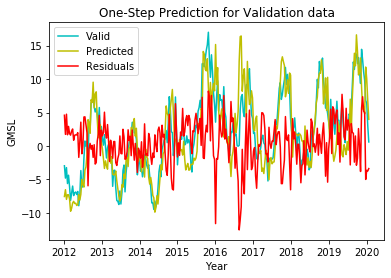

In [140]:
# Increasing the number of layers
nar_res2 = NAR_model(layer_sizes = (10,10,10,),
                   solver = 'lbfgs',
                   act_fun = 'relu')

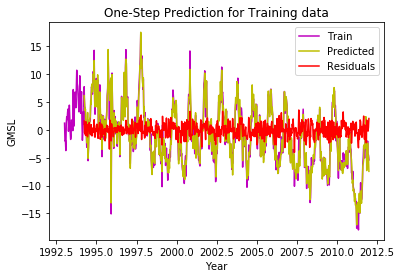

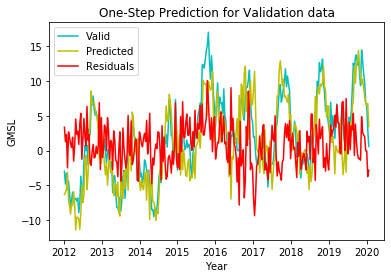

In [141]:
# increasing the layer size keeping layers constant
nar_res3 = NAR_model(layer_sizes = (15,),
                   solver = 'lbfgs',
                   act_fun = 'relu')

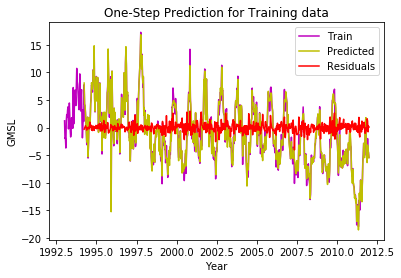

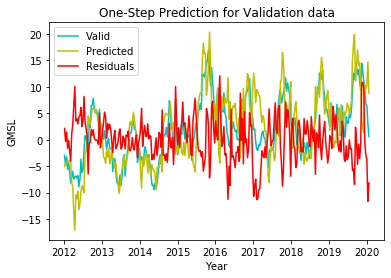

In [152]:
# increasing the layers but with different number of preceptrons in the layers
nar_res4 = NAR_model(layer_sizes = (10,20,30,),
                   solver = 'lbfgs',
                   act_fun = 'relu')

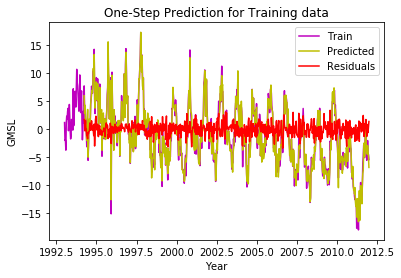

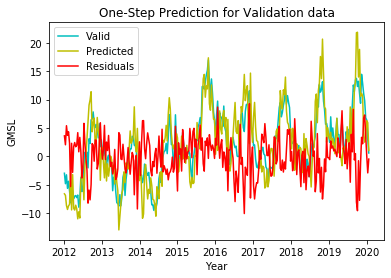

In [149]:
# increasing the number of iterations
nar_res5 = NAR_model(layer_sizes = (10,),
                   solver = 'lbfgs',
                   act_fun = 'relu',max_iter=1000)

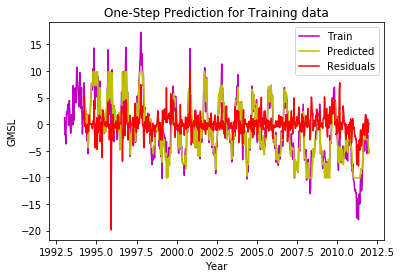

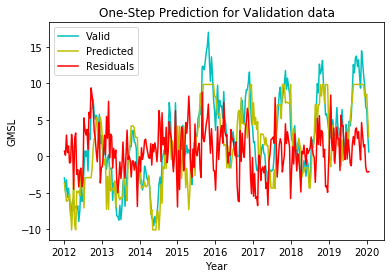

In [143]:
# changing the activation function
nar_res5 = NAR_model(layer_sizes = (10,),
                   solver = 'lbfgs',
                   act_fun = 'tanh')

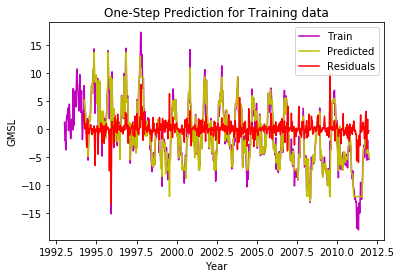

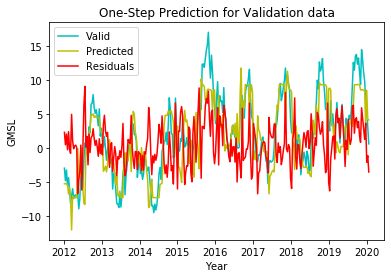

In [144]:
# increasing the number of layers with tanh function 
nar_res6 = NAR_model(layer_sizes = (10,10,10,),
                   solver = 'lbfgs',
                   act_fun = 'tanh')

C:\Users\pisup\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


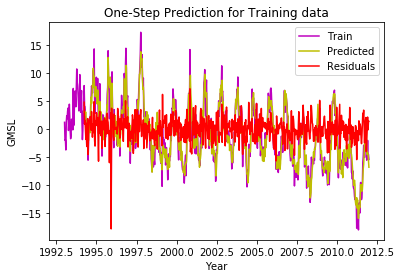

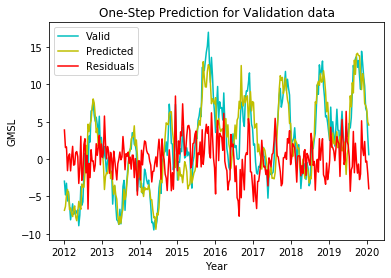

In [150]:
# chnaging the solver
nar_res7 = NAR_model(layer_sizes = (10,),
                   solver = 'sgd',
                   act_fun = 'relu')

C:\Users\pisup\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


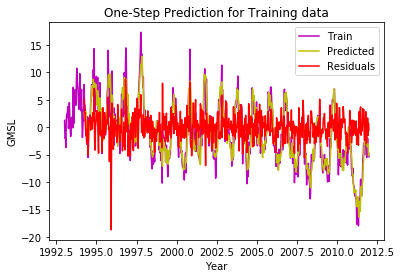

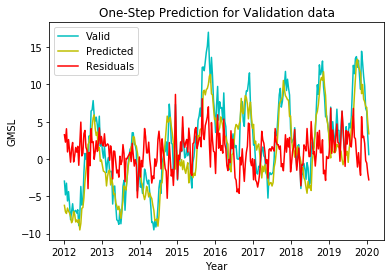

In [151]:
nar_res8 = NAR_model(layer_sizes = (10,),
                   solver = 'adam',
                   act_fun = 'relu')